<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/images/color_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following file represents a simple NN that will do color classification and test model on a real image to see how it responds.



In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

Utils


In [ ]:
import numpy as np
import colorsys

def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(*(x / 255.0 for x in rgb))

def hsv_to_rgb(hsv):
    return [int(x * 255) for x in colorsys.hsv_to_rgb(*hsv)]

def enhance_color(rgb, brightness=1.2, saturation=1.0):
    h, s, v = rgb_to_hsv(rgb)
    s = min(s * saturation, 1.0)
    v = min(v * brightness, 1.0)
    return hsv_to_rgb((h, s, v))


The create_color_dataset function generates a synthetic dataset of solid-color images, each filled with a specific RGB color at a given intensity and resolution.

In [ ]:
import numpy as np
from PIL import Image
import torch

def create_color_dataset(num_colors=10, image_size=(64, 64), intensity=1.2, device='cpu'):
    color_map = {
        'red':      [255, 0, 0],
        'green':    [0, 255, 0],
        'blue':     [0, 0, 255],
        'yellow':   [255, 255, 0],
        'cyan':     [0, 255, 255],
        'magenta':  [255, 0, 255],
        'black':    [0, 0, 0],
        'white':    [255, 255, 255],
        'gray':     [128, 128, 128],
        'orange':   [255, 165, 0],
    }

    def scale_rgb(rgb):
        return np.clip(np.array(rgb) * intensity, 0, 255).astype(np.float32)

    intensity = 1.2

    solid_color_arrays = {
        color: (
            np.full((*image_size, 3), enhance_color(rgb, brightness=intensity), dtype=np.float32)
            if device == 'cpu' else
            torch.tensor(np.full((*image_size, 3), enhance_color(rgb, brightness=intensity), dtype=np.float32)).to(device)
        )
        for color, rgb in color_map.items()
    }


    return solid_color_arrays

color_dataset = create_color_dataset(intensity=5, device=device)

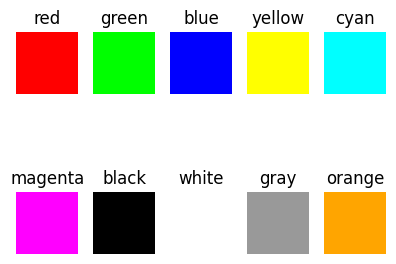

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(4, 4))
axes = axes.flatten()  # Convert the 2D array of axes to a 1D array

for i, (color_name, color_array) in enumerate(color_dataset.items()):
    if i < len(axes):
      # Handle potential device issues (GPU tensors)
      if isinstance(color_array, torch.Tensor):
          color_array = color_array.cpu().numpy()

      axes[i].imshow(color_array.astype(np.uint8)) # Display as an image
      axes[i].set_title(color_name)
      axes[i].axis('off') # Hide axis ticks and labels


plt.tight_layout() # Adjust layout for better spacing
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X = []
y = []
color_to_index = {color: i for i, color in enumerate(color_dataset)}

for color_name, color_array in color_dataset.items():
    if isinstance(color_array, torch.Tensor):
      color_array = color_array.cpu().numpy()
    X.append(color_array.reshape(1, -1))
    y.append(color_to_index[color_name])

X = np.concatenate(X)
y = np.array(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

# Create a dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define the neural network
class ColorClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ColorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Initialize the model, loss function, and optimizer
input_size = 64 * 64 * 3
hidden_size = 128
output_size = len(color_dataset)  # Number of colors
model = ColorClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10  # Adjust the number of epochs
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")


Epoch [1/500], Loss: 0.0000
Epoch [101/500], Loss: 0.0883
Epoch [201/500], Loss: 3.7468
Epoch [301/500], Loss: 0.8166
Epoch [401/500], Loss: 0.0000
Training finished.


In [ ]:
!wget https://raw.githubusercontent.com/andandandand/image-dataset-curation/refs/heads/main/images/red_apple_2.png -O red_app
!wget https://raw.githubusercontent.com/andandandand/image-dataset-curation/refs/heads/main/images/green_apple_2.png -O green_apple_2.png
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/Champ_de_bl%C3%A9_C%C3%B4te-d%27Or_Bourgogne_avril_2014.jpg/960px-Champ_de_bl%C3%A9_C%C3%B4te-d%27Or_Bourgogne_avril_2014.jpg -O green.jpg

--2025-05-08 09:11:52--  https://raw.githubusercontent.com/andandandand/image-dataset-curation/refs/heads/main/images/red_apple_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770325 (752K) [image/png]
Saving to: ‘red_app’

red_app             100%[===================>] 752.27K  --.-KB/s    in 0.02s   

2025-05-08 09:11:52 (34.2 MB/s) - ‘red_app’ saved [770325/770325]

--2025-05-08 09:11:52--  https://raw.githubusercontent.com/andandandand/image-dataset-curation/refs/heads/main/images/green_apple_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting r

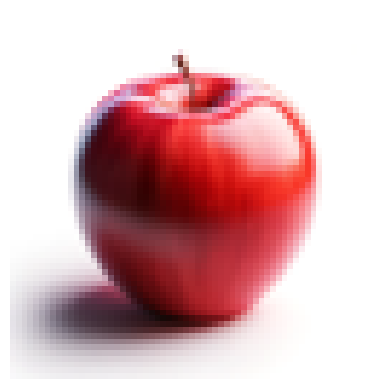

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
try:
  img = Image.open('red_apple_2.png')
except FileNotFoundError:
  print("Error: 'red_apple_2.png' not found. Please ensure the file exists.")
  exit()

# Resize the image
img = img.resize((64, 64))

# Ensure the image has 3 channels (RGB)
if img.mode != 'RGB':
    img = img.convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
img_tensor = torch.tensor(np.array(img), dtype=torch.float32).reshape(1, -1).to(device)
logits = model(img_tensor)
np.argmax(logits.detach().cpu().numpy())

np.int64(0)

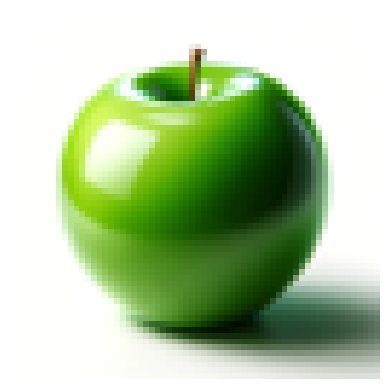

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
try:
  img = Image.open('green_apple_2.png')
except FileNotFoundError:
  print("Error: 'green_apple_1.png' not found. Please ensure the file exists.")
  exit()

# Resize the image
img = img.resize((64, 64))

# Ensure the image has 3 channels (RGB)
if img.mode != 'RGB':
    img = img.convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
img_tensor = torch.tensor(np.array(img), dtype=torch.float32).reshape(1, -1).to(device)
logits = model(img_tensor)
np.argmax(logits.detach().cpu().numpy())

np.int64(4)

In [ ]:
for color in color_dataset:
  img_tensor = torch.tensor(np.array(color_dataset[color].to('cpu').numpy()), dtype=torch.float32).reshape(1, -1).to(device)
  logits = model(img_tensor)
  print(color, np.argmax(logits.detach().cpu().numpy()))


red 0
green 1
blue 2
yellow 3
cyan 4
magenta 5
black 6
white 7
gray 7
orange 9


In [ ]:
!wget https://cdn.sanity.io/images/599r6htc/regionalized/a26fe0cf37bcc164980bcf8014817652df9683a7-1440x810.png -O green.png

--2025-05-08 09:14:16--  https://cdn.sanity.io/images/599r6htc/regionalized/a26fe0cf37bcc164980bcf8014817652df9683a7-1440x810.png
Resolving cdn.sanity.io (cdn.sanity.io)... 34.149.250.58
Connecting to cdn.sanity.io (cdn.sanity.io)|34.149.250.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13126 (13K) [image/png]
Saving to: ‘green.png’

green.png           100%[===================>]  12.82K  --.-KB/s    in 0s      

2025-05-08 09:14:16 (91.6 MB/s) - ‘green.png’ saved [13126/13126]



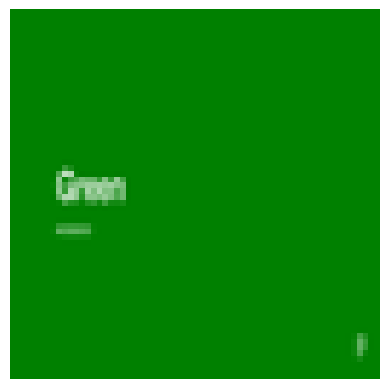

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
try:
  img = Image.open('green.png')
except FileNotFoundError:
  print("Error: 'green.png' not found. Please ensure the file exists.")
  exit()

# Resize the image
img = img.resize((64, 64))

# Ensure the image has 3 channels (RGB)
if img.mode != 'RGB':
    img = img.convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
img_tensor = torch.tensor(np.array(img), dtype=torch.float32).reshape(1, -1).to(device)
logits = model(img_tensor).to(device)
np.argmax(logits.detach().cpu().numpy())
logits_np = logits.detach().cpu().numpy()

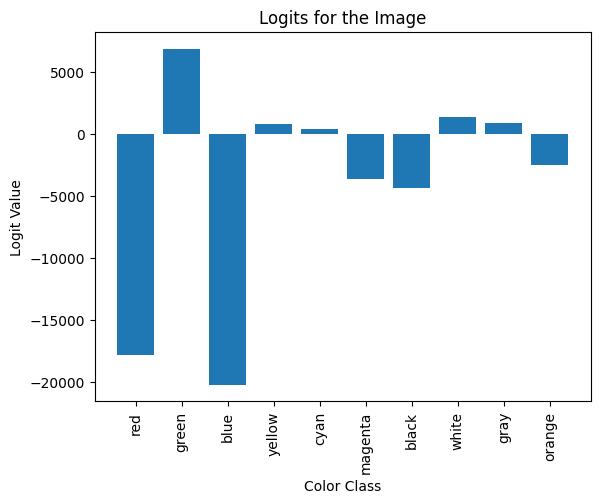

In [ ]:
# Plot the logits (example: bar plot)
plt.bar(np.arange(logits_np.shape[1]), logits_np[0])
plt.xticks(np.arange(logits_np.shape[1]), color_dataset.keys(), rotation=90)  # Set x-axis labels
plt.title("Logits for the Image")
plt.xlabel("Color Class")
plt.ylabel("Logit Value")
plt.show()

In [ ]:
logits

tensor([[-17837.8965,   6880.1226, -20215.4375,    798.4867,    427.7125,
          -3652.9905,  -4367.3511,   1395.6509,    879.7606,  -2536.6113]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
import torch
W1 = torch.tensor([4.0], requires_grad=True)
X1 = torch.tensor([5.0], requires_grad=True)
Y = torch.tensor([6.0], requires_grad=True)

L = torch.abs(W1 * X1 - Y)
print (f'l = {L.item()}, requires_grad = {L.requires_grad}')
L.backward()
print(W1.grad)
L = torch.abs(W1 * X1 - Y)
print (f'l = {L.item()}, requires_grad = {L.requires_grad}')
L.backward()
print(W1.grad)

l = 14.0, requires_grad = True
tensor([5.])
l = 14.0, requires_grad = True
tensor([10.])
